# SDM

In [104]:
using SpeciesDistributionToolkit
using CairoMakie
using Statistics
CairoMakie.activate!(px_per_unit = 6.0)

In [105]:
tx = taxon("Akodon montensis")

GBIF taxon -- Akodon montensis


In [106]:
place = SpeciesDistributionToolkit.gadm("PRY")
extent = SpeciesDistributionToolkit.boundingbox(place)

(left = -62.642398834228516, right = -54.25859832763672, bottom = -27.60569953918457, top = -19.29520034790039)

In [120]:
provider = RasterData(WorldClim2, BioClim)
L = SDMLayer{Float16}[mask!(SDMLayer(provider; resolution=0.5, layer=l, extent...), place) for l in ["BIO1", "BIO12", "BIO3", "BIO8"]]

4-element Vector{SDMLayer{Float16}}:
 SDMLayer{Float16}(Float16[20.97 20.97 … 20.06 20.05; 21.03 21.03 … 20.3 20.14; … ; 24.88 24.88 … 23.67 23.8; 24.9 24.89 … 23.92 23.98], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], (-62.66666666666667, -54.25), (-27.625, -19.291666666666668), "+proj=longlat +datum=WGS84 +no_defs")
 SDMLayer{Float16}(Float16[666.0 674.0 … 1.796e3 1.795e3; 668.0 674.0 … 1.788e3 1.793e3; … ; 580.0 575.0 … 1.455e3 1.46e3; 586.0 579.0 … 1.462e3 1.458e3], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], (-62.66666666666667, -54.25), (-27.625, -19.291666666666668), "+proj=longlat +datum=WGS84 +no_defs")
 SDMLayer{Float16}(Float16[50.6 50.78 … 53.3 53.44; 50.78 50.94 … 53.22 53.28; … ; 64.5 64.4 … 66.4 66.4; 64.7 64.75 … 66.44 66.44], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], (-62.66666666666667, -54.25), (-27.625, -19.291666666666668), "+proj=longlat +datum=WGS84 +no_defs")
 SDMLayer{Float16}(Float16[25.61 25.61 … 17.27 17.23; 25.66 25.66 … 17.47

In [109]:
presences = occurrences(tx, first(L), "occurrenceStatus" => "PRESENT", "country" => "PY", "limit" => 300, "hasCoordinate" => true)
occurrences!(presences)

262-element Vector{GBIFRecord}:
 GBIF record 4857925786	Akodon montensis	(Paraguay)

 GBIF record 4857918537	Akodon montensis	(Paraguay)

 GBIF record 4858002583	Akodon montensis	(Paraguay)

 GBIF record 4858005386	Akodon montensis	(Paraguay)

 GBIF record 4857918544	Akodon montensis	(Paraguay)

 GBIF record 4858002590	Akodon montensis	(Paraguay)

 GBIF record 4858005387	Akodon montensis	(Paraguay)

 GBIF record 4857918545	Akodon montensis	(Paraguay)

 GBIF record 4858005391	Akodon montensis	(Paraguay)

 GBIF record 4857909918	Akodon montensis	(Paraguay)

 ⋮
 GBIF record 1919667148	Akodon montensis	(Paraguay)

 GBIF record 1919667069	Akodon montensis	(Paraguay)

 GBIF record 1919667139	Akodon montensis	(Paraguay)

 GBIF record 1919667154	Akodon montensis	(Paraguay)

 GBIF record 1919667180	Akodon montensis	(Paraguay)

 GBIF record 4916588978	BOLD:AAJ6931	(Paraguay)

 GBIF record 4916474431	BOLD:AAJ6931	(Paraguay)

 GBIF record 4916398582	BOLD:AAJ6931	(Paraguay)

 GBIF record 4913147672

In [121]:
presencelayer = mask(first(L), presences)
background = pseudoabsencemask(DistanceToEvent, presencelayer)
bgpoints = backgroundpoints(nodata(background, d -> d < 4), 2sum(presencelayer))

SDM Layer with 20263 Bool cells
	Proj string: +proj=longlat +datum=WGS84 +no_defs
	Grid size: (200, 202)

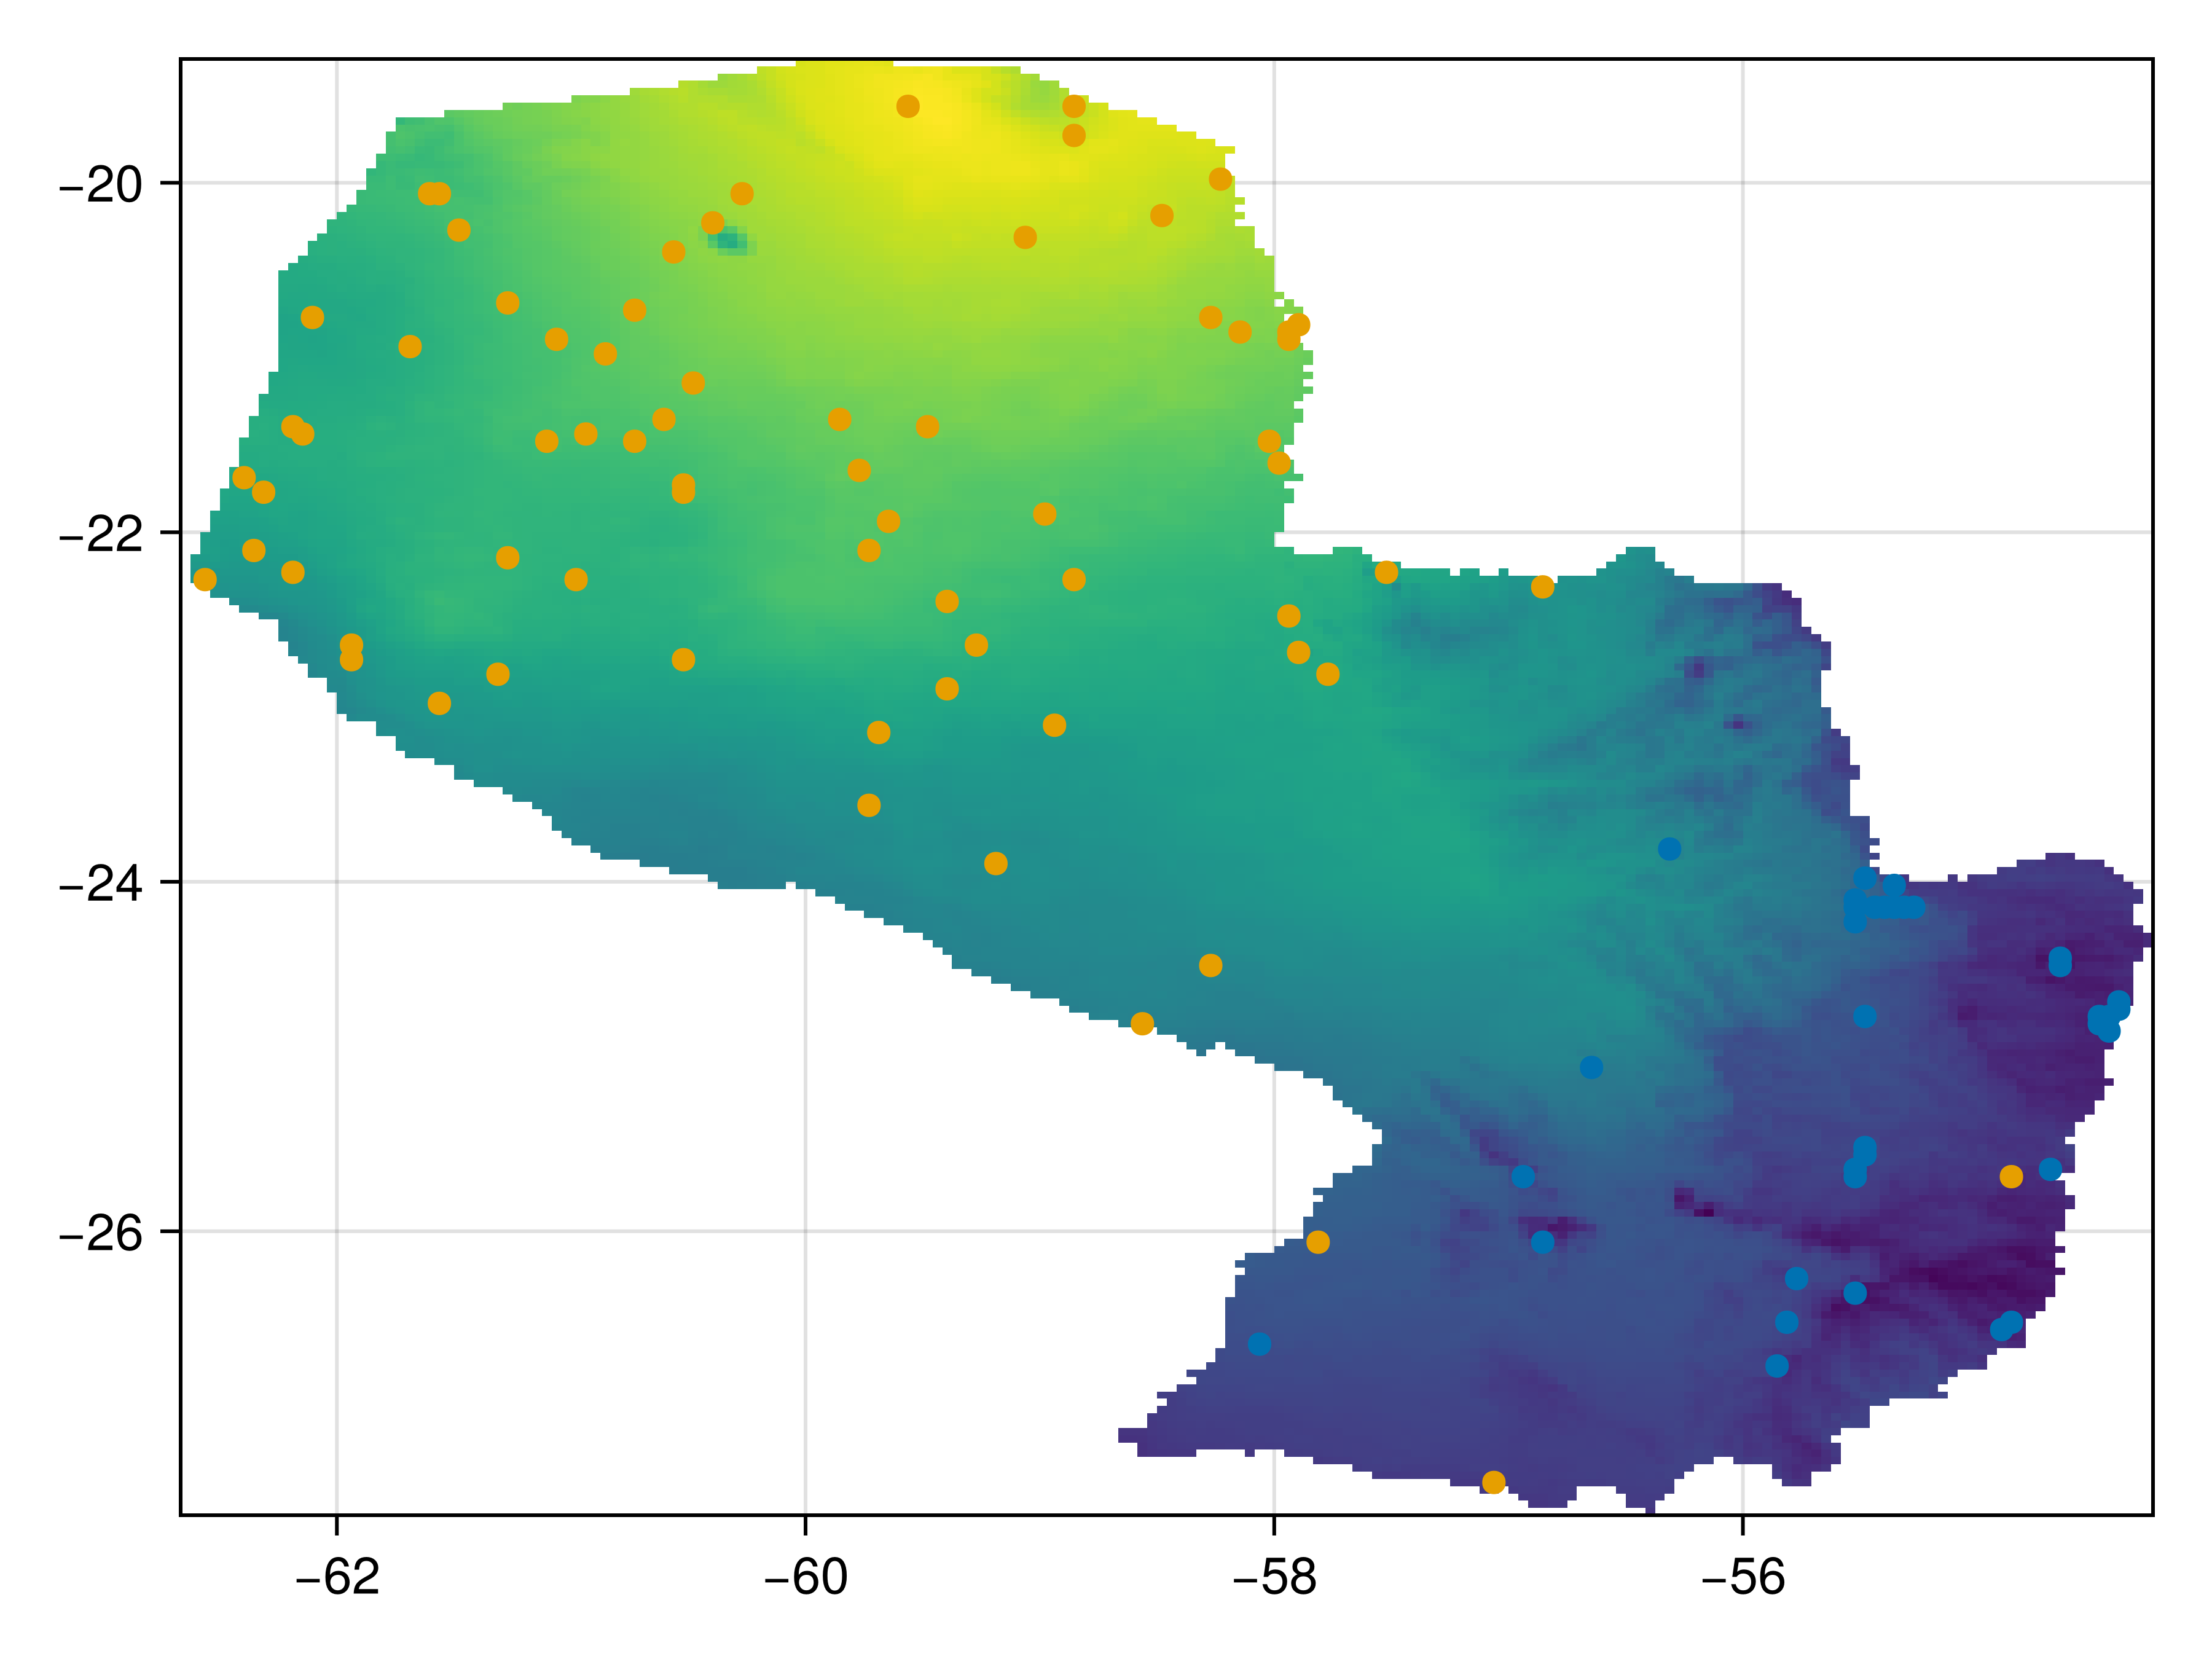

In [122]:
heatmap(L[1])
scatter!(presencelayer)
scatter!(bgpoints)
current_figure()

In [127]:
sdm = SDM(PCATransform, DecisionTree, L, presencelayer, bgpoints)

PCATransform → DecisionTree → P(x) ≥ 0.5

In [128]:
folds = kfold(sdm);
cv = crossvalidate(sdm, folds; threshold = true);
mean(mcc.(cv.validation))

0.8810092587300982

In [129]:
train!(sdm)

PCATransform → DecisionTree → P(x) ≥ 0.019

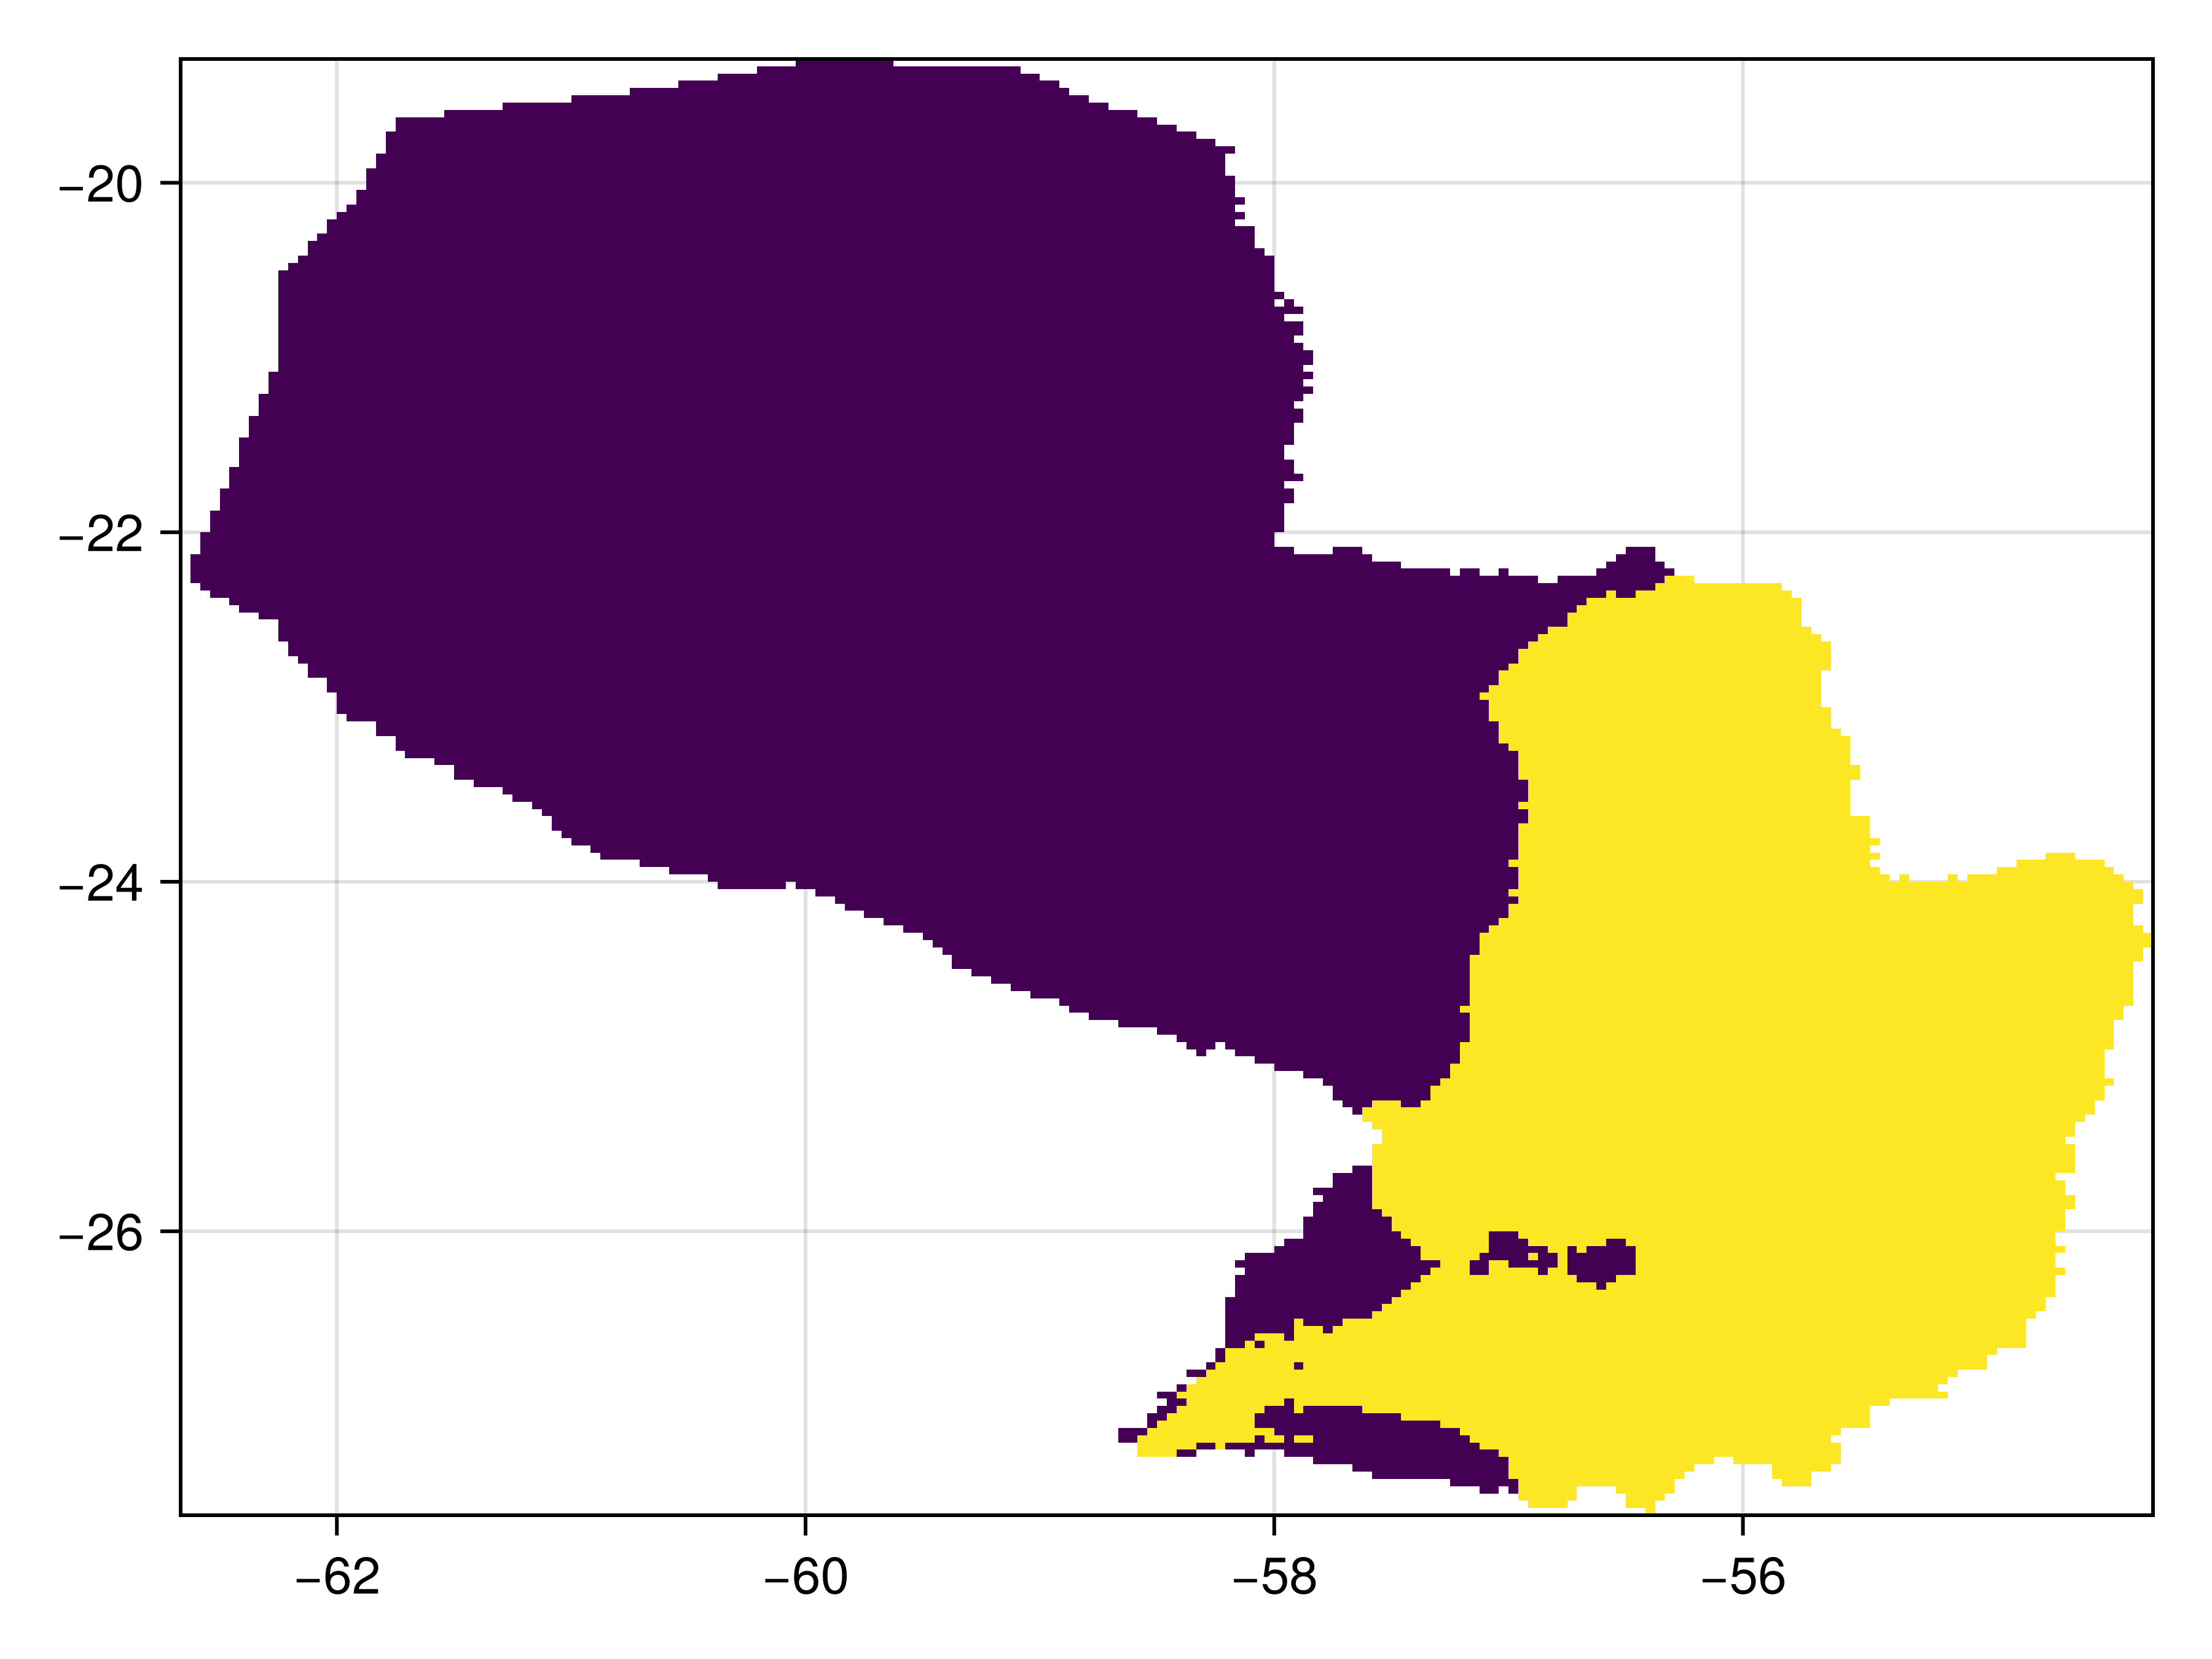

In [131]:
predict(sdm, L; threshold=true) |> heatmap

In [132]:
ensemble = Bagging(sdm, 30)
bagfeatures!(ensemble)

{PCATransform → DecisionTree → P(x) ≥ 0.019} × 30

In [133]:
train!(ensemble)

{PCATransform → DecisionTree → P(x) ≥ 0.019} × 30

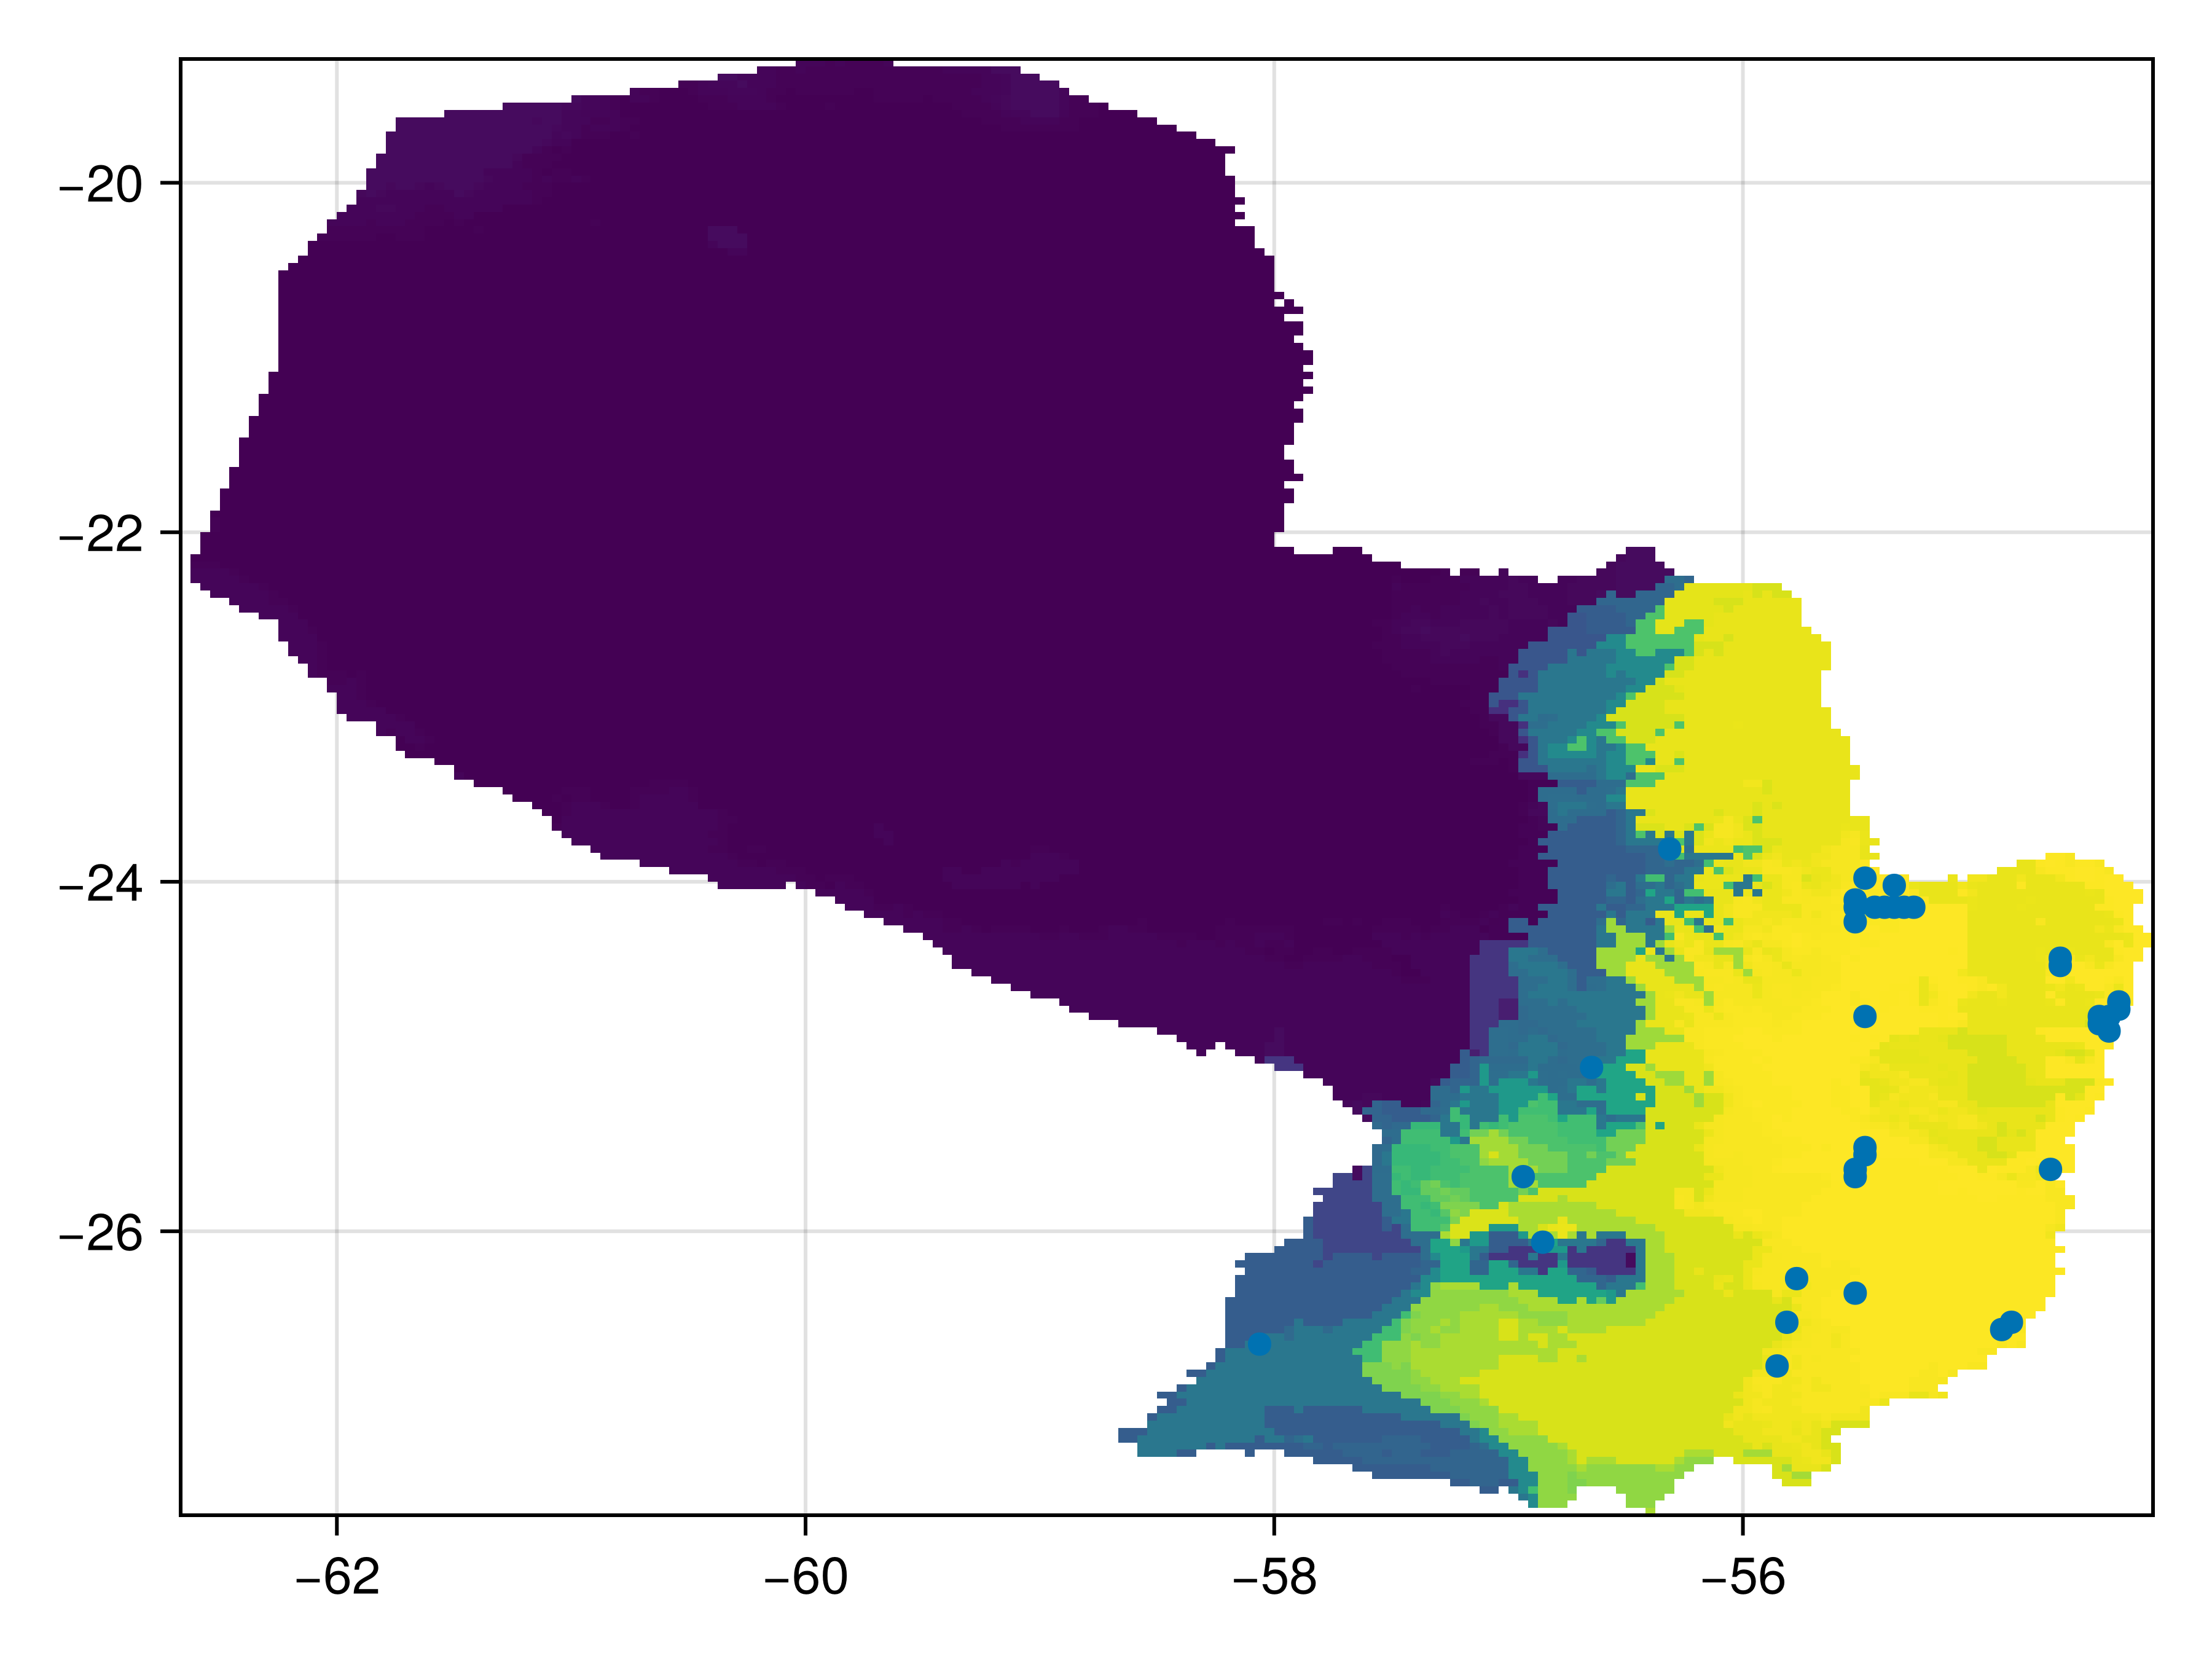

In [134]:
predict(ensemble, L; threshold=false) |> heatmap
scatter!(presencelayer)
current_figure()